<a href="https://colab.research.google.com/github/jobellet/fast_and_rich_decoding_in_VLPFC/blob/main/reproduce_monkeyH_timing_figure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the python notebook reproducing suplementary figure 4 C and D of the paper:
# "Decoding rapidly presented visual stimuli from prefrontal ensembles without report nor post-perceptual processing"


By setting the variable "reproduce_all" to True in the next cell, you can choose to run all the computations starting from the spike times. This will take some time but it ensures that all the analysis steps, starting from the spike times relative to stimulus onset, leads to the results presented in the paper. Otherwise, you can leave the variable "reproduce_all" to False and the results of intermediate computations will be downloaded instead of being recomputed. You can simply run all the cells by pressing Ctrl+F9 in colab

In [26]:
reproduce_all = False # if set to True all the computations will be performed from scratch by this notebook.
                     #  if set to False the results of long computation will be downloaded to quickly display the figures 

import urllib.request
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from matplotlib import pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy import stats
import numpy.matlib
from skimage.measure import label
import seaborn as sb
from tqdm import tqdm


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = "Arial"
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# functions for loading data
def get_monkeyH_df():
    try:
        df = pd.read_pickle('monkeyH.pkl')
    except:
        link_to_monkeyH_data = 'https://ndownloader.figshare.com/files/27946635?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_data,'monkeyH.pkl')
        df = pd.read_pickle('monkeyH.pkl')
    return df

# functions for PSTH
def getSpikemat(spiketimes,mint=-.1,maxt=.4):
    '''
    Bin spiketimes at 1 kHz, single stimuli / trials
    '''
    t_total = int((maxt-mint)*1000) # total time bins
    nch = len(spiketimes)
    spikemat = np.zeros((nch,t_total)).astype(bool)
    for ch in range(nch):
        tms = np.round(spiketimes[ch]*1000).astype(int) - 1 #0-indexing
        
        tms = tms[(tms>=mint*1000) & (tms<maxt*1000)] - int(mint*1000)
        if len(tms)>0:
            spikemat[ch,tms] = 1
   
    return spikemat

def gen_time_bin(binsize,overlap,mint=-.1,maxt=.4):
    all_bins = []
    for i in range(int(binsize/overlap)):
        all_bins.append(np.arange(mint,maxt,binsize)+overlap*i)
    time_bins = np.sort(np.concatenate(all_bins)).astype(int)
    return(time_bins)

def rate_binning(spike_times,time_bins,binsize):
    time_bins = time_bins/1000 # convert in s
    binsize = binsize/1000 # convert in s
    average = np.zeros((len(spike_times),len(time_bins)))
    for i,t in enumerate(time_bins):
        
        for chan in range(len(spike_times)):
            include = (spike_times[chan]>t) & (spike_times[chan]<(t+binsize))
            average[chan,i] = sum(include)/binsize
    return(average)

import scipy

def binomtest(array):
    pval=np.zeros(array.shape[1])
    for i in range(array.shape[1]):
        pval[i]=scipy.stats.binom_test(sum(array[:,i]),array.shape[0])
    return(pval)

# global parameters
nch = 96 # number of channels in the Utah array
sf = 30000; # sampling frequency
tmin = -50 #ms, time before each stim
tmax = 150 #ms, time after each stim

# parameters for binning and normalization
binsize = 50 #ms
overlap = 5 #ms
time_bins = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)
df = get_monkeyH_df()


# Monkey H

## Obtain normalized firing rate from spike time 

In [29]:
# download data from figshare

def get_monkeyH_firing_rate():
    try:
        Rb = np.load('monkeyH_raw_firing_rate.npy')
        Rc = np.load('monkeyH_normalized_firing_rate.npy')
        
    except:
        link_to_monkeyH_raw_firing_rate = 'https://ndownloader.figshare.com/files/28232841?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_raw_firing_rate,'monkeyH_raw_firing_rate.npy')
        
        link_to_monkeyH_nomalized_firing_rate = 'https://ndownloader.figshare.com/files/28232877?private_link=203b69f9ea28fce41084'
        urllib.request.urlretrieve(link_to_monkeyH_nomalized_firing_rate,'monkeyH_normalized_firing_rate.npy')
        Rb = np.load('monkeyH_raw_firing_rate.npy')
        Rc = np.load('monkeyH_normalized_firing_rate.npy')
    return Rb,Rc

if reproduce_all:
    # create PFC PSTH
    ntr = len(df) # number of stimuli presentations

    nbins = len(time_bins)
    Rb = np.zeros((ntr,nch,nbins)) # this will store the firing rate
    Rc = np.zeros((ntr,nch,nbins)) # this will store the normalized firing rate
    for tr in tqdm(range(ntr)): # loop through every stimuli presentations
        Rb[tr,:] = rate_binning(df['Spikes'].iloc[tr],time_bins,binsize)

    ## center each channel
    for sesID in np.unique(np.array(df.sesID)):
        for ch in range(nch):
            Rc[df.sesID == sesID,ch,:] = (Rb[df.sesID == sesID,ch,:] - np.mean(Rb[df.sesID == sesID,ch,:])) / (np.std(Rb[df.sesID == sesID,ch,:]) + 10e-6) # center each channel for each session independentl
    np.save('monkeyH_PFC_5ms_step_raw_firing_rate.npy',Rb)
    np.save('monkeyH_PFC_5ms_step_normalized_firing_rate.npy',Rc)

    # create PPC PSTH
    ntr = len(df) # number of stimuli presentations

    nbins = len(time_bins)
    PPC_Rb = np.zeros((ntr,nch,nbins)) # this will store the firing rate
    PPC_Rc = np.zeros((ntr,nch,nbins)) # this will store the normalized firing rate
    for tr in tqdm(range(ntr)): # loop through every stimuli presentations
        PPC_Rb[tr,:] = rate_binning(df['PPC_Spikes'].iloc[tr],time_bins,binsize)

    ## center each channel
    for sesID in np.unique(np.array(df.sesID)):
        for ch in range(nch):
            PPC_Rc[df.sesID == sesID,ch,:] = (PPC_Rb[df.sesID == sesID,ch,:] - np.mean(PPC_Rb[df.sesID == sesID,ch,:])) / (np.std(PPC_Rb[df.sesID == sesID,ch,:]) + 10e-6) # center each channel for each session independentl
    np.save('monkeyH_PPC_5ms_step_raw_firing_rate.npy',PPC_Rb)
    np.save('monkeyH_PPC_5ms_step_normalized_firing_rate.npy',PPC_Rc)
else:
    Rb,Rc = get_monkeyH_firing_rate()

# Train with slow-paced stimuli

In [32]:
import itertools
all_pairs = np.array(list(itertools.combinations(range(18),2)))

In [33]:
all_pairs[0][0]
nstim = len(np.unique(df.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50

# index
single_stim = (np.array(df.TrialID)>390)  # select only stimuli presentation being followed by an other stimulus 400 ms after the onset
single_stim = single_stim & np.concatenate(([False],single_stim[:-1])) # select only stimuli presentation being preceded by an other stimulus 400 ms before the onset

RSVP = np.array(df.duration >= 0.040) & np.array(df.duration <= 0.060) & np.array(df.TrialID < 110)
RSVP = RSVP & np.concatenate(([False],RSVP[:-1]))

all_disc_single_stim = np.zeros((all_pairs.shape[0],len(t)))
all_disc_RSVP = np.zeros((all_pairs.shape[0],len(t)))

K = 10 # number of training folds
nbins = len(t) # number of time bins
sessions = np.unique(np.array(df.sesID).astype(int))


print(sum(single_stim))

X = Rc[:,np.mean(Rb[:,:,0],axis = 0)>1,:] # The firing rate
Y = np.array(df.StimID).astype(int)
ntr = X.shape[0]
ntest = int(ntr/K)
shuffle = np.random.permutation(ntr)# permutation of every trial

#Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
all_disc_single_stim = np.zeros((all_pairs.shape[0],len(t)))
all_disc_RSVP = np.zeros((all_pairs.shape[0],len(t)))
all_accuracy_single_stim = np.zeros((all_pairs.shape[0],len(t)))
all_accuracy_RSVP = np.zeros((all_pairs.shape[0],len(t)))
corresponding_proba = np.zeros((len(Y),len(t)))
for p in tqdm(range(all_pairs.shape[0])):
    part_of_pair = (Y == all_pairs[p,0]) |  (Y == all_pairs[p,1])
    for k in range(K):
        
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:]
        testind = testind[part_of_pair[testind]]
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[single_stim[trainind] & part_of_pair[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)

            Proba = model.predict_proba(X[testind,:,b])
            for indexation,pp in enumerate(all_pairs[p,:]):
            
                corresponding_proba[testind[Y[testind]==pp],b] = np.squeeze(Proba[Ytest==pp,indexation])>.5
        
        array = corresponding_proba[part_of_pair&single_stim,:]>.5
        all_accuracy_single_stim[p,:] = np.mean(array,axis = 0)
        all_disc_single_stim[p,:] = binomtest(array)
        array = corresponding_proba[part_of_pair&RSVP,:]>.5
        all_accuracy_RSVP[p,:] = np.mean(array,axis = 0)
        all_disc_RSVP[p,:] = binomtest(array); 
    np.save('monkeyH_PFC_trainsingle_5ms_all_disc_single_stim.npy',all_disc_single_stim) 
    np.save('monkeyH_PFC_trainsingle_5ms_all_disc_RSVP.npy',all_disc_RSVP) 
    np.save('monkeyH_PFC_trainsingle_5ms_all_accuracy_single_stim.npy',all_accuracy_single_stim) 
    np.save('monkeyH_PFC_trainsingle_5ms_all_accuracy_RSVP.npy',all_accuracy_RSVP) 

4039


100%|██████████| 153/153 [14:20<00:00,  5.62s/it]


## Figure S4 C

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


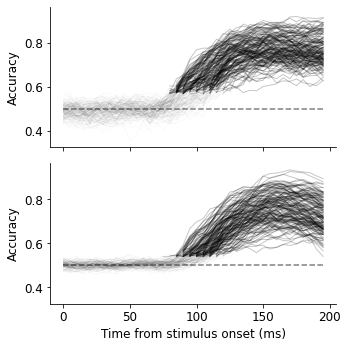

In [34]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50
corrected_stats = multipletests(all_disc_single_stim.flatten(), alpha=0.0001, method='fdr_bh', is_sorted=False, returnsorted=False)
corrected_pval_single = np.reshape(corrected_stats[1],[all_disc_single_stim.shape[0],all_disc_single_stim.shape[1]])
corrected_stats = multipletests(all_disc_RSVP.flatten(), alpha=0.0001, method='fdr_bh', is_sorted=False, returnsorted=False)
corrected_pval_RSVP = np.reshape(corrected_stats[1],[all_disc_single_stim.shape[0],all_disc_single_stim.shape[1]])
first_cross_single_stim = np.zeros(all_pairs.shape[0]).astype(int)
first_cross_RSVP = np.zeros(all_pairs.shape[0]).astype(int)
fig,ax = plt.subplots(2,1,figsize = (5,5),sharex=True,sharey=True)
for p in range(all_pairs.shape[0]):
    
    
    ax[0].plot(t,all_accuracy_single_stim[p,:],'k',alpha = .2,linewidth=.1)
    clusters = label(corrected_pval_single[p,:]<10**-2)
    ax[0].plot(t[clusters==max(clusters)],all_accuracy_single_stim[p,clusters==max(clusters)],'k',alpha = .2,linewidth=1)
    
    first_cross_single_stim[p] = np.where(clusters==max(clusters))[0][0]
    
    ax[1].plot(t,all_accuracy_RSVP[p,:],'k',alpha = .2,linewidth=.1)
    clusters = label(corrected_pval_RSVP[p,:]<10**-2)
    first_cross_RSVP[p] = np.where(clusters==max(clusters))[0][0]
    ax[1].plot(t[clusters==max(clusters)],all_accuracy_RSVP[p,clusters==max(clusters)],'k',alpha = .2,linewidth=1)
    
first_cross_single_stim = t[first_cross_single_stim]
first_cross_RSVP = t[first_cross_RSVP]
ax[0].plot([t[0],t[-1]],[.5,.5],'--k',alpha = .5)
ax[1].plot([t[0],t[-1]],[.5,.5],'--k',alpha = .5)   
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Accuracy')
ax[-1].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
plt.tight_layout()
fig.savefig('FigureS4C.pdf')
fig.savefig('FigureS4C.jpg',dpi = 600)

In [35]:
print('Mdn =' + str(np.median(first_cross_single_stim)))
print('2.5% =' + str(np.sort(first_cross_single_stim)[np.round(.025*len(first_cross_single_stim)).astype(int)]))
print('97.5% =' + str(np.sort(first_cross_single_stim)[np.round(.975*len(first_cross_single_stim)).astype(int)]))


print('Mdn =' + str(np.median(first_cross_RSVP)))
print('2.5% =' + str(np.sort(first_cross_RSVP)[np.round(.025*len(first_cross_RSVP)).astype(int)]))
print('97.5% =' + str(np.sort(first_cross_RSVP)[np.round(.975*len(first_cross_RSVP)).astype(int)]))

Mdn =95.0
2.5% =80
97.5% =120
Mdn =100.0
2.5% =85
97.5% =120


# Train with stimuli in RSVP sequence

In [37]:
all_pairs[0][0]
nstim = len(np.unique(df.StimID))

t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50

# index
single_stim = (np.array(df.TrialID)>390)  # select only stimuli presentation being followed by an other stimulus 400 ms after the onset
single_stim = single_stim & np.concatenate(([False],single_stim[:-1])) # select only stimuli presentation being preceded by an other stimulus 400 ms before the onset

RSVP = np.array(df.duration >= 0.040) & np.array(df.duration <= 0.060) & np.array(df.TrialID < 110)
RSVP = RSVP & np.concatenate(([False],RSVP[:-1]))


K = 10 # number of training folds
nbins = len(t) # number of time bins
sessions = np.unique(np.array(df.sesID).astype(int))

print(sum(RSVP))

X = Rc[:,np.mean(Rb[:,:,0],axis = 0)>1,:] # The firing rate
Y = np.array(df.StimID).astype(int)
ntr = X.shape[0]
ntest = int(ntr/K)
shuffle = np.random.permutation(ntr)# permutation of every trial

#Proba = np.zeros((ntr,nstim,nbins))# predictive probability prealocation
corresponding_proba = np.zeros((ntr,nbins)) # predictive probability for concerned item prealocation
for p in tqdm(range(all_pairs.shape[0])):
    part_of_pair = (Y == all_pairs[p,0]) |  (Y == all_pairs[p,1])
    for k in range(K):
        
        testind = shuffle[k*ntest:(k+1)*ntest] # index of trial being tested
        if k == K-1:
            testind = shuffle[k*ntest:]
        testind = testind[part_of_pair[testind]]
        Ytest = Y[testind].astype(int)
        trainind = np.delete(shuffle,np.arange(k*ntest,(k+1)*ntest)) # index of trial being used for training
        trainind = trainind[RSVP[trainind] & part_of_pair[trainind]] # Keeping only long ISI 
        Xtrain = X[trainind,:]
        Ytrain = Y[trainind]

        for b in range(nbins):
            model = LogisticRegression(fit_intercept=False,solver='lbfgs',multi_class='auto',max_iter=10000).fit(Xtrain[:,:,b],Ytrain)

            Proba = model.predict_proba(X[testind,:,b])
            for indexation,pp in enumerate(all_pairs[p,:]):
            
                corresponding_proba[testind[Y[testind]==pp],b] = np.squeeze(Proba[Ytest==pp,indexation])
        array = corresponding_proba[part_of_pair&single_stim,:]>.5
        all_accuracy_single_stim[p,:] = np.mean(array,axis = 0)
        all_disc_single_stim[p,:] = binomtest(array)
        array = corresponding_proba[part_of_pair&RSVP,:]>.5
        all_accuracy_RSVP[p,:] = np.mean(array,axis = 0)
        all_disc_RSVP[p,:] = binomtest(array); 
np.save('monkeyH_PFC_trainRSVP_5ms_all_disc_single_stim.npy',all_disc_single_stim) 
np.save('monkeyH_PFC_trainRSVP_5ms_all_disc_RSVP.npy',all_disc_RSVP) 
np.save('monkeyH_PFC_trainRSVP_5ms_all_accuracy_single_stim.npy',all_accuracy_single_stim) 
np.save('monkeyH_PFC_trainRSVP_5ms_all_accuracy_RSVP.npy',all_accuracy_RSVP) 


11979


100%|██████████| 153/153 [14:57<00:00,  5.87s/it]


## Figure S4 D

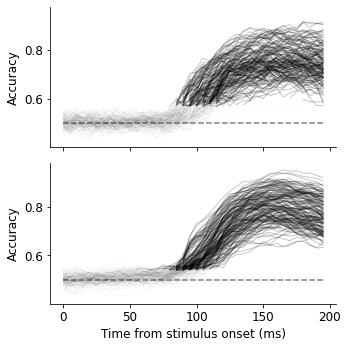

In [38]:
t = gen_time_bin(binsize,overlap,mint=tmin,maxt=tmax)+50
corrected_stats = multipletests(all_disc_single_stim.flatten(), alpha=0.0001, method='fdr_bh', is_sorted=False, returnsorted=False)
corrected_pval_single = np.reshape(corrected_stats[1],[all_disc_single_stim.shape[0],all_disc_single_stim.shape[1]])
corrected_stats = multipletests(all_disc_RSVP.flatten(), alpha=0.0001, method='fdr_bh', is_sorted=False, returnsorted=False)
corrected_pval_RSVP = np.reshape(corrected_stats[1],[all_disc_single_stim.shape[0],all_disc_single_stim.shape[1]])
first_cross_single_stim = np.zeros(all_pairs.shape[0]).astype(int)
first_cross_RSVP = np.zeros(all_pairs.shape[0]).astype(int)
fig,ax = plt.subplots(2,1,figsize = (5,5),sharex=True,sharey=True)
for p in range(all_pairs.shape[0]):
    
    
    ax[0].plot(t,all_accuracy_single_stim[p,:],'k',alpha = .2,linewidth=.1)
    clusters = label(corrected_pval_single[p,:]<10**-2)
    ax[0].plot(t[clusters==max(clusters)],all_accuracy_single_stim[p,clusters==max(clusters)],'k',alpha = .2,linewidth=1)
    
    first_cross_single_stim[p] = np.where(clusters==max(clusters))[0][0]
    
    ax[1].plot(t,all_accuracy_RSVP[p,:],'k',alpha = .2,linewidth=.1)
    clusters = label(corrected_pval_RSVP[p,:]<10**-2)
    first_cross_RSVP[p] = np.where(clusters==max(clusters))[0][0]
    ax[1].plot(t[clusters==max(clusters)],all_accuracy_RSVP[p,clusters==max(clusters)],'k',alpha = .2,linewidth=1)
    
first_cross_single_stim = t[first_cross_single_stim]
first_cross_RSVP = t[first_cross_RSVP]
ax[0].plot([t[0],t[-1]],[.5,.5],'--k',alpha = .5)
ax[1].plot([t[0],t[-1]],[.5,.5],'--k',alpha = .5)   
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Accuracy')
ax[-1].set_xlabel('Time from stimulus onset (ms)')
sb.despine()
plt.tight_layout()
fig.savefig('FigureS4D.pdf')
fig.savefig('FigureS4D.jpg',dpi = 600)

In [ ]:

print('Mdn =' + str(np.median(first_cross_single_stim)))
print('2.5% =' + str(np.sort(first_cross_single_stim)[np.round(.025*len(first_cross_single_stim)).astype(int)]))
print('97.5% =' + str(np.sort(first_cross_single_stim)[np.round(.975*len(first_cross_single_stim)).astype(int)]))


print('Mdn =' + str(np.median(first_cross_RSVP)))
print('2.5% =' + str(np.sort(first_cross_RSVP)[np.round(.025*len(first_cross_RSVP)).astype(int)]))
print('97.5% =' + str(np.sort(first_cross_RSVP)[np.round(.975*len(first_cross_RSVP)).astype(int)]))